In [9]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
'''
  ████
██    ██   Datature
  ██  ██   Powering Breakthrough AI
    ██

@File    :   dicom_nifti_demo.ipynb
@Author  :   Koh Quan Wei Ivan
@Version :   1.0
@Contact :   hello@datature.io
@License :   Apache License 2.0
@Desc    :   Demo for visualizing and uploading DICOM and NIFTI files using Datature Python SDK.
'''


'\n  ████\n██    ██   Datature\n  ██  ██   Powering Breakthrough AI\n    ██\n\n@File    :   dicom_nifti_demo.ipynb\n@Author  :   Koh Quan Wei Ivan\n@Version :   1.0\n@Contact :   hello@datature.io\n@License :   Apache License 2.0\n@Desc    :   <Description>\n'

# Install required libraries

In [ ]:
! pip install --upgrade datature

# Import Libraries

In [1]:
import os
import datature
import time 
import ipywidgets as widgets
import pydicom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
import dicom2nifti
from vedo import Volume, settings
from vedo.applications import Slicer3DPlotter
settings.default_backend = 'ipyvtklink'

# Importing DICOM or NIFTI files

Nexus currently has support for the following single file uploads

This means that the following cases will work without any need for modification:
1. Single NIFTI files containing slices of a single volume
2. Single DICOM files containing slices 

The following cases will require some modification to the code:

3. Multiple DICOM files in a directory representing a single volume

## Data Paths

In [2]:
# change to your own data 
nifti_file_path = "data/BRAINIX_NIFTI_Output_3D_File.nii"
dicom_file_path = "data/0009.DCM"
dicom_folder_path = "data/T2"

## 1. Import a NIFTI file representing a volume

In [3]:
loaded_nifti = nib.load(nifti_file_path)
nifti_array = loaded_nifti.get_fdata()
print(nifti_array.shape)


(512, 512, 22)


In [4]:
# get pixel spacing and slice thickness
slice_thickness = loaded_nifti.header["pixdim"][3]
# index 1 and 2 are the pixel spacing in x and y directions
pixel_spacing = loaded_nifti.header["pixdim"][1:3]
print("Slice thickness: ", slice_thickness)
print("Pixel spacing: ", pixel_spacing)


Slice thickness:  5.0
Pixel spacing:  [0.46875 0.46875]


In [5]:
nifti_array.shape
img3d = nifti_array

num_slices = img3d.shape[2]
num_cols = img3d[0].shape[1]
num_rows = img3d[0].shape[0]

print("Number of slices: ", num_slices)
print("Number of columns: ", num_cols)
print("Number of rows: ", num_rows)

print(nifti_array.shape)

Number of slices:  22
Number of columns:  22
Number of rows:  512
(512, 512, 22)


### NIFTI: Interactive slicer through the axial, sagittal and coronal planes

In [6]:
axial_aspect = pixel_spacing[1] / pixel_spacing[0]  # y/x elongation of pixels in the y direction relative to the x direction
sagittal_aspect = pixel_spacing[1] / slice_thickness  # y/z
coronal_aspect = slice_thickness / pixel_spacing[0]  # z/x

img3d = nifti_array 

num_slices = img3d.shape[2]
num_cols = img3d[0].shape[1]
num_rows = img3d[0].shape[0]

x,y,z = img3d.shape

@widgets.interact(
    axial_slice=(0, z - 1),
    coronal_slice=(0, y - 1),
    sagittal_slice=(0, x - 1),
)
def slicer(axial_slice, coronal_slice, sagittal_slice):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img3d[:, :, axial_slice])
    ax[0].set_title("Axial Slice")
    ax[0].axis("off")
    ax[0].set_aspect(axial_aspect)

    ax[1].imshow(img3d[:, coronal_slice, :].T)
    ax[1].set_title("Coronal Slice")
    ax[1].axis("off")
    ax[1].set_aspect(coronal_aspect)

    ax[2].imshow(img3d[sagittal_slice, :, :])
    ax[2].set_title("Sagittal Slice")
    ax[2].axis("off")
    ax[2].set_aspect(sagittal_aspect)

interactive(children=(IntSlider(value=10, description='axial_slice', max=21), IntSlider(value=255, description…

### NIFTI: Preview the volume in 3D

(Volume)0x29d085a00
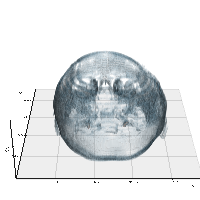

In [13]:
nifti_vol = Volume(nifti_array, spacing=[pixel_spacing[0], pixel_spacing[1], slice_thickness])
nifti_vol

### NIFTI: Interactive slicer through volume

In [14]:
nifti_vol = Volume(nifti_array, spacing=[pixel_spacing[0], pixel_spacing[1], slice_thickness])
# create a slicer for the nifti file for all 3 planes: axial, coronal, sagittal
plotter = Slicer3DPlotter(nifti_vol, bg='blackboard', bg2='lightblue')
plotter.show()
plotter.close()

## 2. Import a DICOM file representing slices

In [7]:
dicom_file = pydicom.dcmread(dicom_file_path)
dicom_array = dicom_file.pixel_array
print(dicom_array.shape)

(137, 512, 512)


### DICOM: Interactive slicer

In [8]:
# interactive slicer for dicom file
num_slices = dicom_array.shape[0]


@widgets.interact(slice=(0, num_slices - 1))
def dicom_slicer(slice):
    plt.imshow(dicom_array[slice], cmap=plt.cm.bone)
    plt.axis("off")
    plt.show()


interactive(children=(IntSlider(value=68, description='slice', max=136), Output()), _dom_classes=('widget-inte…

## 3. Import multiple DICOM files representing a volume

In [19]:
dicom_files = os.listdir(dicom_folder_path)
# remove non-dicom files
dicom_files = [file for file in dicom_files if file.endswith(".dcm")]
dicom_files = [os.path.join(dicom_folder_path, file) for file in dicom_files]
# sort by slice location, if available else sort by filename
dicom_files.sort(
    key=lambda x: pydicom.dcmread(x, force=True).SliceLocation
    if hasattr(pydicom.dcmread(x, force=True), "SliceLocation")
    else x
)


### Multiple DICOM files: Interactive slicer through the axial, sagittal and coronal planes

In [25]:
# assume files in directory are all from the same series and sorted
slices = [pydicom.dcmread(f) for f in dicom_files]

# number of slices
num_slices = len(slices)
# number of rows in each slice
num_rows = slices[0].pixel_array.shape[0]
# number of columns in each slice
num_cols = slices[0].pixel_array.shape[1]

# pixel aspects, assuming all slices are the same

# if pixel size not available in dicom file, assume an isotropic voxel size of 1
if hasattr(slices[0], "PixelSpacing") and hasattr(slices[0], "SliceThickness"):
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
else:
    ps = [1, 1]
    ss = 1

# ps = slices[0].PixelSpacing
# ss = slices[0].SliceThickness
axial_aspect = ps[1] / ps[0]  # y/x
sagittal_aspect = ps[1] / ss  # y/z
coronal_aspect = ss / ps[0]  # z/x

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d


@widgets.interact(
    axial_slice=(0, num_slices - 1),
    coronal_slice=(0, num_cols - 1),
    sagittal_slice=(0, num_rows - 1),
)
def slicer(axial_slice, coronal_slice, sagittal_slice):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img3d[:, :, axial_slice])
    ax[0].set_title("Axial Slice")
    ax[0].axis("off")
    ax[0].set_aspect(axial_aspect)

    ax[1].imshow(img3d[coronal_slice, :, :].T)
    ax[1].set_title("Coronal Slice")
    ax[1].axis("off")
    ax[1].set_aspect(coronal_aspect)

    ax[2].imshow(img3d[:, sagittal_slice, :])
    ax[2].set_title("Sagittal Slice")
    ax[2].axis("off")
    ax[2].set_aspect(sagittal_aspect)


interactive(children=(IntSlider(value=10, description='axial_slice', max=21), IntSlider(value=255, description…

### Multiple DICOM files: Preview volume 

(Volume)0x2a5e542e0
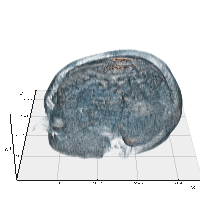

In [21]:
vol = Volume(img3d)
vol = Volume(img3d, spacing=[ps[0], ps[1], ss])
vol

### Multiple DICOM files: Interactive slicer through the volume

This opens an interactive window separate from the notebook. Close the window to continue the notebook.

In [99]:
vol = Volume(img3d, spacing=[ps[0], ps[1], ss])

plotter = Slicer3DPlotter(
    vol,
    bg="black",
    bg2="black",
    show_histo=False,
)

plotter.close()

### Example: Combine DICOM files into a single NIFTI file

Multiple DICOM files in a directory can be converted in to NIFTI volume, then uploaded to Nexus

This is because Nexus currently does not support the upload to DICOM directories.

In [7]:
# combine DICOM files into a single NIFTI

output_folder_path = "/Users/ivankoh/Downloads"
dicom2nifti.convert_directory(dicom_folder_path, output_folder_path, compression=True, reorient=True)

# Upload DICOM/NIFTI files to Datature Nexus

The steps are as follows:
1. Create a new project on Nexus and retrieve the [secret key](https://developers.datature.io/docs/hub-and-api) in the `Integrations` page.
2. Use Datature SDK to upload the DICOM/NIFTI files to Datature Nexus

For NIFTI files, each file is uploaded as a separate 3D volume.
- If the axis of orientation is provided, the SDK will upload a series of 2D slices corresponding to the specified orientation. You will only see one asset containing multiple slices on Nexus.
- If the axis of orientation is not provided, the SDK will upload a series of 2D slices for each orientation (x, y, z). This means that you will see three separate assets on Nexus.

For DICOM files, only single file uploads are supported. 
- Each single DICOM file can either represent a single image or a series of 2D slices of a 3D volume.
- This means that if you have a 3D volume from multiple stacked DICOM files, you can either:
    - Convert it to a NIFTI file for upload, or 
    - Upload DICOM files consisting of 2D series for each orientation separately.

## Example: Initialize an upload session to upload a NIFTI file (no orientation specified)

In [ ]:
datature.secret_key = "YOUR_SECRET_KEY"
single_nifti_file_path = nifti_file_path

upload_session = datature.Asset.upload_session()

# upload the single NIFTI file containing a 3D volume
upload_session.add(
    single_nifti_file_path
)  # this will upload axial, coronal, sagittal planes separately

# start the upload session
upload_session.start(["main"], background=True)


In [ ]:
# check the status of the upload
num_files = 3
while datature.Operation.retrieve(
        op_link)["status"]["progress"]["with_status"]["finished"] != num_files:
    time.sleep(1)
print(f"Uploaded '{nifti_file_path}' to Nexus!")

## Example: Initialize upload session to upload a NIFTI file (with specified orientation)

In [ ]:
single_nifti_file_path = nifti_file_path

upload_session = datature.Asset.upload_session()

# upload the single NIFTI file containing a 3D volume
upload_session.add(single_nifti_file_path, orientation="x")  # x orientation

# start the upload session in the background
# and retrieve the operation link for status checks
op_link = upload_session.start(['main'], background=True)["op_link"]


In [ ]:
# check the status of the upload
num_files = 1
while datature.Operation.retrieve(
        op_link)["status"]["progress"]["with_status"]["finished"] != num_files:
    time.sleep(1)
print(f"Uploaded '{single_nifti_file_path}' to Nexus!")

## Example: Initialize an upload session to upload a DICOM file

In [ ]:
single_dicom_file_path = dicom_file_path

upload_session = datature.Asset.upload_session()

# upload the single DICOM file containing a series of slices 
upload_session.add(dicom_file_path)

# start the upload session in the background
# and retrieve the operation link for status checks
op_link = upload_session.start(['main'], background=True)["op_link"]

In [ ]:
# check the status of the upload
num_files = 1
while datature.Operation.retrieve(
        op_link)["status"]["progress"]["with_status"]["finished"] != num_files:
    time.sleep(1)
print(f"Uploaded '{single_dicom_file_path}' to Nexus!")